In [16]:
from collections import defaultdict
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sqlite3

In [17]:
conn = sqlite3.connect('data/supply_chain.db')

In [18]:
pd.read_sql_query("""
    SELECT *
    FROM countries
""", conn).T

,0
id,CR
name,Costa Rica
total_production,86164791
num_farmers,32899
num_middlemen,165
num_exporters,31
max_buyers_per_farmer,3
max_exporters_per_middleman,3
farmer_production_sigma,0.8
middleman_capacity_sigma,0.5


In [19]:
pd.read_sql_query("""
    SELECT *
    FROM farmers
""", conn)

,id,geography_id,country_id,num_plots,production_amount,loyalty
0,cr_ssu_abangares_F000000,cr_ssu_abangares,CR,1,1076.0,0.059435
1,cr_ssu_abangares_F000001,cr_ssu_abangares,CR,1,214.0,0.524053
2,cr_ssu_abangares_F000002,cr_ssu_abangares,CR,2,129.0,0.763669
3,cr_ssu_abangares_F000003,cr_ssu_abangares,CR,3,260.0,0.815372
4,cr_ssu_abangares_F000004,cr_ssu_abangares,CR,3,747.0,0.068125
...,...,...,...,...,...,...
32827,cr_ssu_valverde_vega_F000615,cr_ssu_valverde_vega,CR,3,731.0,0.263964
32828,cr_ssu_valverde_vega_F000616,cr_ssu_valverde_vega,CR,3,4027.0,0.540008
32829,cr_ssu_valverde_vega_F000617,cr_ssu_valverde_vega,CR,1,694.0,0.413464
32830,cr_ssu_valverde_vega_F000618,cr_ssu_valverde_vega,CR,2,3421.0,0.486148


In [20]:
df = pd.read_sql_query("""
    SELECT * FROM trading_relationships
    JOIN farmers ON trading_relationships.farmer_id = farmers.id
    JOIN middlemen ON trading_relationships.middleman_id = middlemen.id
    WHERE farmers.loyalty < middlemen.loyalty
""", conn)
df

,year,country_id,farmer_id,middleman_id,exporter_id,sold_to_eu,amount_kg,id,geography_id,country_id,num_plots,production_amount,loyalty,id,country_id,competitiveness,loyalty
0,0,CR,cr_ssu_abangares_F000000,CR_M000016,CR_E000003,1,10,cr_ssu_abangares_F000000,cr_ssu_abangares,CR,1,1076.0,0.059435,CR_M000016,CR,0.008235,0.133754
1,0,CR,cr_ssu_abangares_F000000,CR_M000016,CR_E000014,1,6,cr_ssu_abangares_F000000,cr_ssu_abangares,CR,1,1076.0,0.059435,CR_M000016,CR,0.008235,0.133754
2,0,CR,cr_ssu_abangares_F000000,CR_M000016,CR_E000008,0,81,cr_ssu_abangares_F000000,cr_ssu_abangares,CR,1,1076.0,0.059435,CR_M000016,CR,0.008235,0.133754
3,0,CR,cr_ssu_abangares_F000000,CR_M000014,CR_E000025,0,22,cr_ssu_abangares_F000000,cr_ssu_abangares,CR,1,1076.0,0.059435,CR_M000014,CR,0.013027,0.310221
4,0,CR,cr_ssu_abangares_F000000,CR_M000014,CR_E000013,0,161,cr_ssu_abangares_F000000,cr_ssu_abangares,CR,1,1076.0,0.059435,CR_M000014,CR,0.013027,0.310221
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121612,1,CR,cr_ssu_valverde_vega_F000614,CR_M000095,CR_E000002,0,61,cr_ssu_valverde_vega_F000614,cr_ssu_valverde_vega,CR,1,1987.0,0.000000,CR_M000095,CR,0.005836,0.031741
121613,1,CR,cr_ssu_valverde_vega_F000614,CR_M000095,CR_E000016,0,59,cr_ssu_valverde_vega_F000614,cr_ssu_valverde_vega,CR,1,1987.0,0.000000,CR_M000095,CR,0.005836,0.031741
121614,1,CR,cr_ssu_valverde_vega_F000615,CR_M000018,CR_E000001,0,164,cr_ssu_valverde_vega_F000615,cr_ssu_valverde_vega,CR,3,731.0,0.263964,CR_M000018,CR,0.003790,0.339888
121615,1,CR,cr_ssu_valverde_vega_F000615,CR_M000018,CR_E000013,0,411,cr_ssu_valverde_vega_F000615,cr_ssu_valverde_vega,CR,3,731.0,0.263964,CR_M000018,CR,0.003790,0.339888


In [21]:
df = pd.read_sql_query("""
    SELECT * FROM trading_relationships
    JOIN farmers ON trading_relationships.farmer_id = farmers.id
    JOIN geographies ON farmers.geography_id = geographies.id
""", conn)

In [22]:
#df.tail()
#df[df['country'] == 'CO']
#df['amount_kg'].sum()
df

,year,country_id,farmer_id,middleman_id,exporter_id,sold_to_eu,amount_kg,id,geography_id,country_id,...,production_amount,loyalty,id,name,country_id,centroid,producing_area_name,num_farmers,total_production_kg,primary_crop
0,0,CR,cr_ssu_abangares_F000000,CR_M000016,CR_E000003,1,10,cr_ssu_abangares_F000000,cr_ssu_abangares,CR,...,1076.0,0.059435,cr_ssu_abangares,Abangares,CR,"10.258,-85.002",cr_pa_zona_norte,210,143172,arabica
1,0,CR,cr_ssu_abangares_F000000,CR_M000016,CR_E000014,1,6,cr_ssu_abangares_F000000,cr_ssu_abangares,CR,...,1076.0,0.059435,cr_ssu_abangares,Abangares,CR,"10.258,-85.002",cr_pa_zona_norte,210,143172,arabica
2,0,CR,cr_ssu_abangares_F000000,CR_M000016,CR_E000008,0,81,cr_ssu_abangares_F000000,cr_ssu_abangares,CR,...,1076.0,0.059435,cr_ssu_abangares,Abangares,CR,"10.258,-85.002",cr_pa_zona_norte,210,143172,arabica
3,0,CR,cr_ssu_abangares_F000000,CR_M000014,CR_E000025,0,22,cr_ssu_abangares_F000000,cr_ssu_abangares,CR,...,1076.0,0.059435,cr_ssu_abangares,Abangares,CR,"10.258,-85.002",cr_pa_zona_norte,210,143172,arabica
4,0,CR,cr_ssu_abangares_F000000,CR_M000014,CR_E000013,0,161,cr_ssu_abangares_F000000,cr_ssu_abangares,CR,...,1076.0,0.059435,cr_ssu_abangares,Abangares,CR,"10.258,-85.002",cr_pa_zona_norte,210,143172,arabica
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290256,1,CR,cr_ssu_valverde_vega_F000619,CR_M000095,CR_E000002,0,55,cr_ssu_valverde_vega_F000619,cr_ssu_valverde_vega,CR,...,845.0,0.588706,cr_ssu_valverde_vega,Valverde Vega,CR,"10.185,-84.3",cr_pa_valle_occidental,620,1000502,arabica
290257,1,CR,cr_ssu_valverde_vega_F000619,CR_M000095,CR_E000016,0,234,cr_ssu_valverde_vega_F000619,cr_ssu_valverde_vega,CR,...,845.0,0.588706,cr_ssu_valverde_vega,Valverde Vega,CR,"10.185,-84.3",cr_pa_valle_occidental,620,1000502,arabica
290258,1,CR,cr_ssu_valverde_vega_F000619,CR_M000018,CR_E000001,0,89,cr_ssu_valverde_vega_F000619,cr_ssu_valverde_vega,CR,...,845.0,0.588706,cr_ssu_valverde_vega,Valverde Vega,CR,"10.185,-84.3",cr_pa_valle_occidental,620,1000502,arabica
290259,1,CR,cr_ssu_valverde_vega_F000619,CR_M000018,CR_E000013,0,115,cr_ssu_valverde_vega_F000619,cr_ssu_valverde_vega,CR,...,845.0,0.588706,cr_ssu_valverde_vega,Valverde Vega,CR,"10.185,-84.3",cr_pa_valle_occidental,620,1000502,arabica


In [23]:
pd.concat([
    df.groupby('producing_area_name')['farmer_id'].nunique(),
    df.groupby('producing_area_name')['amount_kg'].sum(),
    df.groupby('producing_area_name')['middleman_id'].nunique()    
], axis=1)

# / ).sort_values()

,farmer_id,amount_kg,middleman_id
producing_area_name,,,
cr_pa_brunca_y_turrialba,10260,39287251,45
cr_pa_los_santos,10440,75669920,55
cr_pa_valle_central,3332,27862195,19
cr_pa_valle_occidental,8030,28075157,54
cr_pa_zona_norte,770,1435059,8


<Axes: >

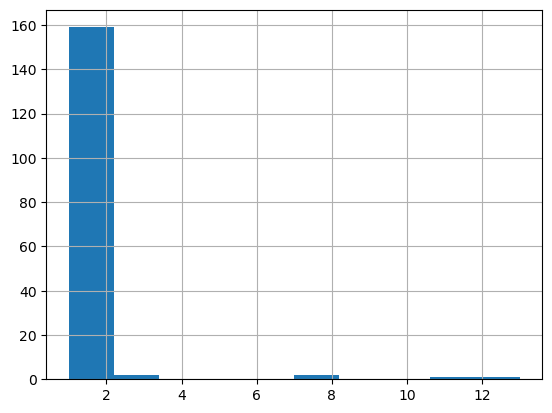

In [24]:
#df[df['middleman_id'] == 'CR_M000002']['geography_id'].nunique()
df.groupby('middleman_id')['geography_id'].nunique().sort_values().hist()

In [25]:
mm = pd.concat([
    df.groupby(['producing_area_name', 'geography_id'])['farmer_id'].nunique(),
    df.groupby(['producing_area_name', 'geography_id'])['amount_kg'].sum(),
    df.groupby(['producing_area_name', 'geography_id'])['middleman_id'].nunique()    
], axis=1)

mm['ratio'] = (mm['amount_kg'] / mm['middleman_id']).apply(int)
#mm.sort_values(by='ratio')
mm

farmer_id  amount_kg  \
producing_area_name      geography_id                                 
cr_pa_brunca_y_turrialba cr_ssu_buenos_aires         620    1194461   
                         cr_ssu_coto_brus           2300   11236981   
                         cr_ssu_jimenez               90    1504624   
                         cr_ssu_paraiso              550    1986483   
                         cr_ssu_perez_zeledon       5400   18973213   
                         cr_ssu_turrialba           1300    4391489   
cr_pa_los_santos         cr_ssu_acosta              1400    3745291   
                         cr_ssu_aserri               990    4805734   
                         cr_ssu_cartago             1600    6505604   
                         cr_ssu_desamparados        2000    8681027   
                         cr_ssu_dota                 540    6416831   
                         cr_ssu_el_guarco            210    1150045   
                         cr_ssu_leon_cortes         2100   17670028   
                         cr_ssu_tarrazu             1600   26695360   
cr_pa_valle_central      cr_ssu_alajuela             680   10119033   
                         cr_ssu_barva                280    1838892   
                         cr_ssu_curridabat             1     171658   
                         cr_ssu_escazu                70      57631   
                         cr_ssu_heredia               80     550745   
                         cr_ssu_la_union              70    1962976   
                         cr_ssu_moravia               40     996244   
                         cr_ssu_poas                 530    4416463   
                         cr_ssu_puriscal             440    1268380   
                         cr_ssu_san_isidro           160     332467   
                         cr_ssu_san_jose               1      16584   
                         cr_ssu_san_pablo             70     401570   
                         cr_ssu_san_rafael           190    1058819   
                         cr_ssu_santa_ana             90     550535   
                         cr_ssu_santa_barbara        350    2581206   
                         cr_ssu_santo_domingo        220    1125461   
                         cr_ssu_turrubares            60     413531   
cr_pa_valle_occidental   cr_ssu_atenas               620    2090237   
                         cr_ssu_grecia              1300    3026602   
                         cr_ssu_naranjo             1900    8737604   
                         cr_ssu_palmares             880    2071763   
                         cr_ssu_san_mateo             10     214109   
                         cr_ssu_san_ramon           2700    9936487   
                         cr_ssu_valverde_vega        620    1998355   
cr_pa_zona_norte         cr_ssu_abangares            210     285165   
                         cr_ssu_hojancha              60      67149   
                         cr_ssu_montes_de_oro         80      50675   
                         cr_ssu_nandayure             70     262551   
                         cr_ssu_nicoya                40      63595   
                         cr_ssu_puntarenas            90     355943   
                         cr_ssu_san_carlos            40      27106   
                         cr_ssu_tilaran              180     322875   

                                               middleman_id    ratio  
producing_area_name      geography_id                                 
cr_pa_brunca_y_turrialba cr_ssu_buenos_aires              3   398153  
                         cr_ssu_coto_brus                 7  1605283  
                         cr_ssu_jimenez                   4   376156  
                         cr_ssu_paraiso                   2   993241  
                         cr_ssu_perez_zeledon            29   654248  
                         cr_ssu_turrialba                 3  1463829  
cr_pa_los_santos         cr_ssu_acosta                    8   468161  

In [27]:
#df[df['farmer_id'] == 'cr_ssu_valverde_vega_F000619']
df.groupby('farmer_id')['middleman_id'].nunique().value_counts()

middleman_id
2    11559
3     6881
1     4935
4     4409
5     2637
6     2411
Name: count, dtype: int64

In [36]:
def plot_kde(df, group_col, value_col, title, aggfunc='sum'):
    grouped = df.groupby(group_col)[value_col].agg(aggfunc)
    n = len(grouped)
    stats = {
        "total (bags)": grouped.sum() / 60,
        "median (kg)": grouped.median(),
        "std (kg)": grouped.std(),
        "min (kg)": grouped.min(),
        "max (kg)": grouped.max(),
        "total (kg)": grouped.sum(),
    }
    plt.figure(figsize=(10, 3))
    sns.kdeplot(grouped, fill=True)
    plt.title(f"{title} (n={n:,.0f})")
    plt.xlim(0,)
    plt.xlabel("Values")
    plt.ylabel("Density")

    stats_text = "\n".join([f"{k}: {v:,.0f}" for k, v in stats.items()])
    plt.annotate(stats_text, xy=(0.95, 0.5), xycoords="axes fraction", ha="right", fontsize=10)
    plt.tight_layout()
    plt.show()

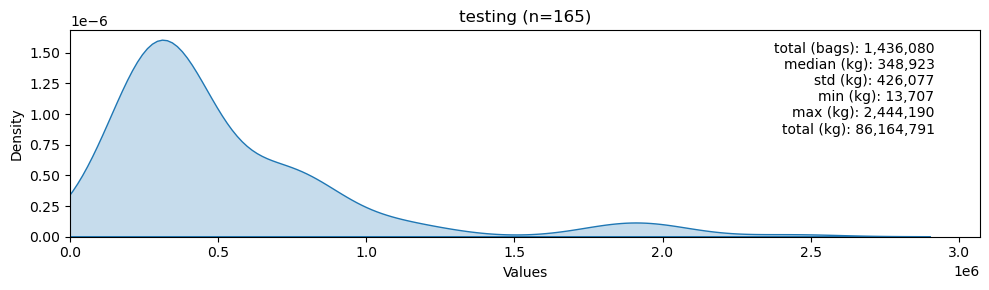

In [37]:
plot_kde(
    df=df,
    group_col='middleman_id',
    value_col='amount_kg',
    title='testing',
    aggfunc='sum'
)

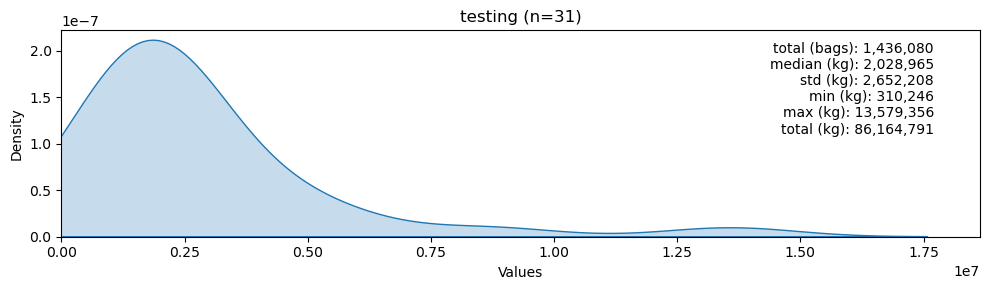

In [38]:
plot_kde(
    df=df,
    group_col='exporter_id',
    value_col='amount_kg',
    title='testing',
    aggfunc='sum'
)

In [39]:
df.groupby('exporter_id')['amount_kg'].sum().sort_values()

exporter_id
CR_E000008      310246
CR_E000017      503155
CR_E000023      603050
CR_E000020      784111
CR_E000019      942889
CR_E000014     1124620
CR_E000015     1144688
CR_E000016     1447727
CR_E000022     1465208
CR_E000012     1597035
CR_E000025     1687385
CR_E000013     1920129
CR_E000006     1973389
CR_E000024     1980244
CR_E000010     1995626
CR_E000028     2028965
CR_E000029     2039070
CR_E000007     2140100
CR_E000005     2150600
CR_E000002     2218484
CR_E000026     2524437
CR_E000021     2564616
CR_E000009     2998621
CR_E000004     3068568
CR_E000003     3168540
CR_E000011     4054132
CR_E000018     4472638
CR_E000027     5220153
CR_E000030     5777008
CR_E000000     8680001
CR_E000001    13579356
Name: amount_kg, dtype: int64

In [40]:
(
    df[df['geography_id'].isin(['cr_ssu_coto_brus'])]
    .pivot_table(
        columns='geography_id',
        index='middleman_id',
        values='amount_kg',
        aggfunc='sum'
    )
)

geography_id,cr_ssu_coto_brus
middleman_id,
CR_M000025,755858
CR_M000068,841660
CR_M000080,856936
CR_M000081,733021
CR_M000100,832582
CR_M000115,791950
CR_M000156,806265


In [41]:
(
    df[df['middleman_id'].isin(['CR_M000144', 'CR_M000164', 'CR_M000131', 'CR_M000121'])]
    .pivot_table(
        columns='geography_id',
        index='middleman_id',
        values='amount_kg',
        aggfunc='sum'
    )
)

geography_id,cr_ssu_paraiso,cr_ssu_perez_zeledon,cr_ssu_san_rafael,cr_ssu_san_ramon
middleman_id,,,,
CR_M000121,NaN,302093.0,NaN,NaN
CR_M000131,491536.0,NaN,NaN,NaN
CR_M000144,NaN,NaN,290685.0,NaN
CR_M000164,NaN,NaN,NaN,312555.0


In [42]:
df['middleman_id'].nunique()

165

In [43]:
df.groupby('geography_id').agg({'middleman_id': 'nunique', 'amount_kg': 'sum'}).sort_values(by='amount_kg').to_dict(orient='records')

[{'middleman_id': 2, 'amount_kg': 8291},
 {'middleman_id': 2, 'amount_kg': 13614},
 {'middleman_id': 2, 'amount_kg': 25423},
 {'middleman_id': 2, 'amount_kg': 28842},
 {'middleman_id': 2, 'amount_kg': 31852},
 {'middleman_id': 2, 'amount_kg': 33632},
 {'middleman_id': 2, 'amount_kg': 80400},
 {'middleman_id': 2, 'amount_kg': 107048},
 {'middleman_id': 2, 'amount_kg': 131274},
 {'middleman_id': 2, 'amount_kg': 142884},
 {'middleman_id': 2, 'amount_kg': 161698},
 {'middleman_id': 2, 'amount_kg': 166080},
 {'middleman_id': 2, 'amount_kg': 178089},
 {'middleman_id': 2, 'amount_kg': 200719},
 {'middleman_id': 2, 'amount_kg': 206711},
 {'middleman_id': 2, 'amount_kg': 275185},
 {'middleman_id': 2, 'amount_kg': 275306},
 {'middleman_id': 2, 'amount_kg': 498079},
 {'middleman_id': 2, 'amount_kg': 529255},
 {'middleman_id': 2, 'amount_kg': 562740},
 {'middleman_id': 2, 'amount_kg': 575112},
 {'middleman_id': 3, 'amount_kg': 596608},
 {'middleman_id': 2, 'amount_kg': 634397},
 {'middleman_id': 2

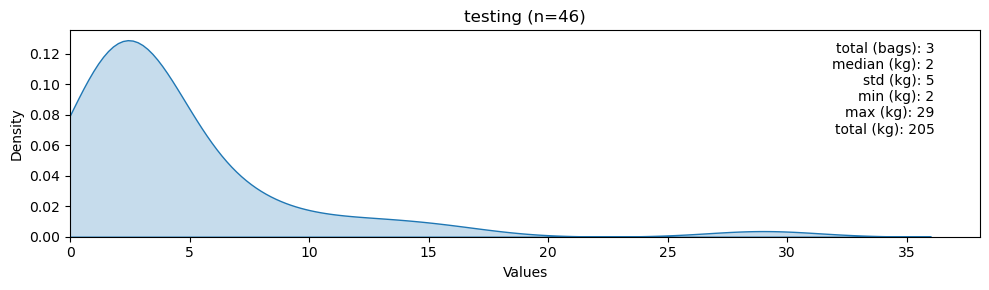

In [44]:
plot_kde(
    df=df,
    group_col='geography_id',
    value_col='middleman_id',
    title='testing',
    aggfunc='nunique'
)

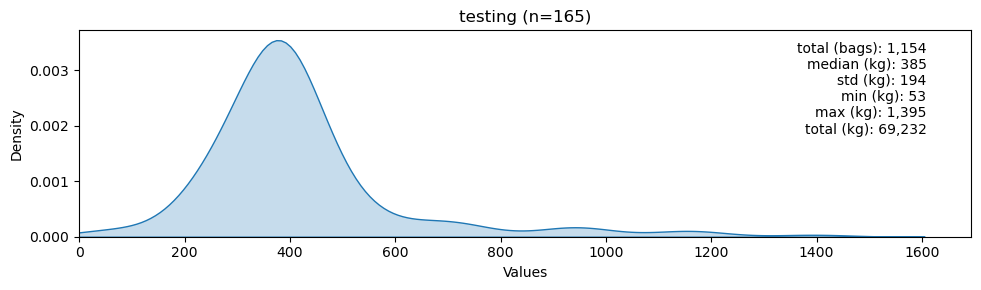

In [45]:
plot_kde(
    df=df,
    group_col='middleman_id',
    value_col='farmer_id',
    title='testing',
    aggfunc='nunique'
)

In [46]:
df.groupby('farmer_id')['middleman_id'].nunique().value_counts()

middleman_id
2    15800
3    10300
1     6732
Name: count, dtype: int64

<Axes: xlabel='geography_id', ylabel='middleman_id'>

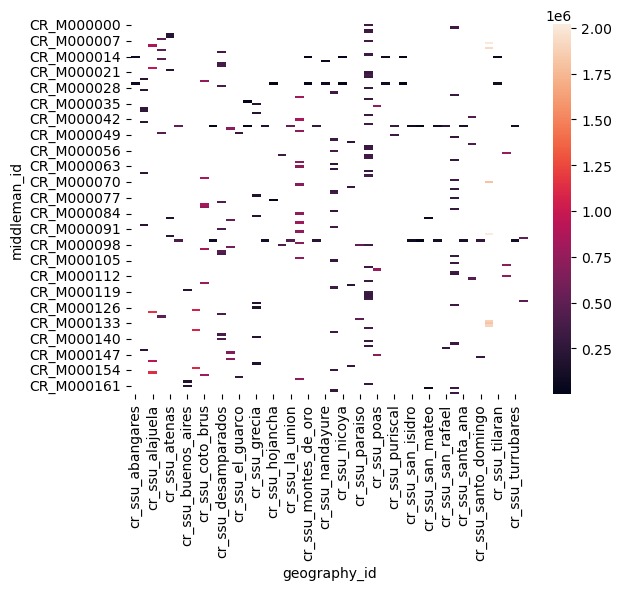

In [47]:
sns.heatmap(df.pivot_table(
    columns='geography_id',
    index='middleman_id',
    values='amount_kg',
    aggfunc='sum')    
)

In [48]:
df.groupby('sold_to_eu')['farmer_id'].nunique()

sold_to_eu
0    31918
1    10002
Name: farmer_id, dtype: int64

In [49]:
df.groupby('sold_to_eu')['amount_kg'].sum()

sold_to_eu
0    73025889
1    13138902
Name: amount_kg, dtype: int64

<Axes: >

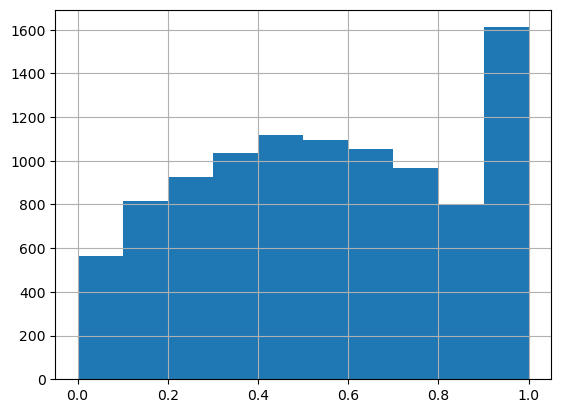

In [58]:
eu = df.pivot_table(index='farmer_id', columns='sold_to_eu', values='amount_kg', fill_value=0)
eu.columns = ['no', 'yes']
eu['total'] = eu.sum(axis=1)
eu['ratio'] = eu['yes'] / eu['total']
eu[eu['ratio']>0]['ratio'].hist()

In [21]:
geo_df = pd.read_csv('data/_local/jebena_geo_map_dataset.csv')
geo_df.tail()

,Geographical Region Code,Geographical Region Label,Geographical Values Value (numeric version),Geographical Values Variable Name
167587,zm_ssu_eastern_zambia,Eastern Zambia,1213580,estimated_arabica_production_in_kg
167588,zm_ssu_western_zambia,Western Zambia,0,estimated_arabica_farmer_population
167589,zm_ssu_western_zambia,Western Zambia,0,estimated_arabica_production_in_kg
167590,zm_ssu_western_zambia,Western Zambia,0,estimated_robusta_farmer_population
167591,zm_ssu_western_zambia,Western Zambia,0,estimated_robusta_production_in_kg


In [22]:
geo_df['Geographical Region  Code'].nunique()

41898

In [19]:
import networkx as nx

In [ ]:
G = nx.DiGraph()

In [2]:
config = SimulationConfig.from_country("Colombia")
sim = Simulation(config)

In [3]:
transactions = sim.seed_supply_chain()

Total simulation time: 1.56s


In [16]:
dff = transactions[transactions['source'].str.contains('FARMER')]

In [18]:
dff.groupby('source')['target'].nunique().sort_values()

source
CO_FARMER_179645    1
CO_FARMER_465523    2
CO_FARMER_036284    2
CO_FARMER_420444    2
CO_FARMER_241609    2
                   ..
CO_FARMER_182682    3
CO_FARMER_182681    3
CO_FARMER_182680    3
CO_FARMER_182694    3
CO_FARMER_547194    3
Name: target, Length: 547195, dtype: int64

In [12]:
sim.config.traceability_rate = 0

In [13]:
eu_exports = sim.simulate_eu_exports()

Total EU export simulation time: 2.11s


In [14]:
farmers = []
for i in eu_exports:
    farmers.extend(i['farmer_ids'])
len(set(farmers))    

547195

In [6]:
import pandas as pd
import numpy as np
from dataclasses import dataclass
import time

In [2]:
@dataclass
class SimulationConfig:
    total_production: int = 10_000_000 * 60
    num_farmers: int = 500_000
    num_middlemen: int = 1000
    num_exporters: int = 100
    max_buyers_per_farmer: int = 3
    max_exporters_per_middleman: int = 3
    farmer_production_sigma: float = 0.8
    middleman_capacity_sigma: float = 0.5
    exporter_pareto_alpha: float = 1.16
    farmer_switch_rate: float = 0.20
    middleman_switch_rate: float = 0.30

In [3]:
def pad_id(identifier, total):
    """Returns a zero-padded string representation of an ID."""
    return str(identifier).zfill(len(str(total)))

In [4]:
def simulate_supply_chain(config):
    
    # Benchmark Start
    start_time = time.time()
    
    # Farmer Volumes
    farmer_volumes = np.random.lognormal(
        mean=np.log(config.total_production / config.num_farmers) - 0.5,
        sigma=config.farmer_production_sigma,
        size=config.num_farmers
    )
    farmer_volumes = farmer_volumes / farmer_volumes.sum() * config.total_production

    # Middleman and Exporter Weights
    middleman_weights = np.random.lognormal(
        mean=np.log(config.total_production / config.num_middlemen) - 0.5 * config.middleman_capacity_sigma**2,
        sigma=config.middleman_capacity_sigma,
        size=config.num_middlemen
    )
    middleman_weights /= middleman_weights.sum()

    exporter_weights = (1 + np.random.pareto(config.exporter_pareto_alpha, config.num_exporters))
    exporter_weights /= exporter_weights.sum()

    # Farmer-to-Middleman Assignments
    farmer_matrix = np.random.choice(
        np.arange(config.num_middlemen),
        size=(config.num_farmers, config.max_buyers_per_farmer),
        p=middleman_weights
    )
    
    # Middleman-to-Exporter Assignments
    middleman_matrix = np.random.choice(
        np.arange(config.num_exporters),
        size=(config.num_middlemen, config.max_exporters_per_middleman),
        p=exporter_weights
    )

    # Farmer-to-Middleman Transactions
    farmer_to_middleman_weights = middleman_weights[farmer_matrix]
    farmer_to_middleman_weights /= farmer_to_middleman_weights.sum(axis=1, keepdims=True)
    farmer_to_middleman_volumes = farmer_to_middleman_weights * farmer_volumes[:, None]

    farmer_to_middleman = pd.DataFrame({
        'source': [f"FARMER_{pad_id(fid, config.num_farmers)}" for fid in np.repeat(np.arange(config.num_farmers), config.max_buyers_per_farmer)],
        'target': [f"MIDDLEMAN_{pad_id(mid, config.num_middlemen)}" for mid in farmer_matrix.flatten()],
        'volume': farmer_to_middleman_volumes.flatten()
    })

    # Middleman-to-Exporter Transactions
    middleman_to_exporter_weights = exporter_weights[middleman_matrix]
    middleman_to_exporter_weights /= middleman_to_exporter_weights.sum(axis=1, keepdims=True)
    middleman_to_exporter_volumes = middleman_to_exporter_weights * farmer_to_middleman.groupby('target')['volume'].sum().values[:, None]

    middleman_to_exporter = pd.DataFrame({
        'source': [f"MIDDLEMAN_{pad_id(mid, config.num_middlemen)}" for mid in np.repeat(np.arange(config.num_middlemen), config.max_exporters_per_middleman)],
        'target': [f"EXPORTER_{pad_id(exp, config.num_exporters)}" for exp in middleman_matrix.flatten()],
        'volume': middleman_to_exporter_volumes.flatten()
    })

    total_time = time.time() - start_time
    print(f"Total simulation time: {total_time:.2f}s")
    
    # Combine Transactions
    return pd.concat([farmer_to_middleman, middleman_to_exporter], ignore_index=True)

def simulate_switches(transactions, config):
    
    start_time = time.time()
    
    # Vectorized Switching
    def switch_targets(df, target_col, switch_rate, new_targets):
        num_switches = int(len(df) * switch_rate)
        switch_indices = np.random.choice(df.index, num_switches, replace=False)
        df.loc[switch_indices, target_col] = np.random.choice(new_targets, size=num_switches)
        return df

    # Farmer-to-Middleman
    farmer_to_middleman = transactions[transactions['source'].str.startswith('FARMER')]
    switched_farmer_to_middleman = switch_targets(
        farmer_to_middleman.copy(),
        target_col='target',
        switch_rate=config.farmer_switch_rate,
        new_targets=[f"MIDDLEMAN_{pad_id(mid, config.num_middlemen)}" for mid in range(config.num_middlemen)]
    )

    # Middleman-to-Exporter
    middleman_to_exporter = transactions[transactions['source'].str.startswith('MIDDLEMAN')]
    switched_middleman_to_exporter = switch_targets(
        middleman_to_exporter.copy(),
        target_col='target',
        switch_rate=config.middleman_switch_rate,
        new_targets=[f"EXPORTER_{pad_id(exp, config.num_exporters)}" for exp in range(config.num_exporters)]
    )
    
    total_time = time.time() - start_time
    print(f"Total switching time: {total_time:.2f}s")

    return pd.concat([switched_farmer_to_middleman, switched_middleman_to_exporter]).sort_index()

In [5]:
# Example Usage
config = SimulationConfig()
d = simulate_supply_chain(config)
d_switched = simulate_switches(d, config)
print(d_switched.head())

Total simulation time: 1.28s
Total switching time: 0.47s
          source          target      volume
0  FARMER_000000  MIDDLEMAN_0610  133.540324
1  FARMER_000000  MIDDLEMAN_0470  244.671519
2  FARMER_000000  MIDDLEMAN_0020  176.858745
3  FARMER_000001  MIDDLEMAN_0245  233.397715
4  FARMER_000001  MIDDLEMAN_0514  421.452925


In [7]:
import polars as pl
import numpy as np
from dataclasses import dataclass
import time

@dataclass
class SimulationConfig:
    total_production: int = 10_000_000 * 60
    num_farmers: int = 500_000
    num_middlemen: int = 1000
    num_exporters: int = 100
    max_buyers_per_farmer: int = 3
    max_exporters_per_middleman: int = 3
    farmer_production_sigma: float = 0.8
    middleman_capacity_sigma: float = 0.5
    exporter_pareto_alpha: float = 1.16
    farmer_switch_rate: float = 0.20
    middleman_switch_rate: float = 0.30

def pad_id(identifier, total):
    """Returns a zero-padded string representation of an ID."""
    return str(identifier).zfill(len(str(total)))

def simulate_supply_chain(config):
    start_time = time.time()

    # Farmer Volumes
    farmer_volumes = np.random.lognormal(
        mean=np.log(config.total_production / config.num_farmers) - 0.5,
        sigma=config.farmer_production_sigma,
        size=config.num_farmers
    )
    farmer_volumes = farmer_volumes / farmer_volumes.sum() * config.total_production

    # Middleman and Exporter Weights
    middleman_weights = np.random.lognormal(
        mean=np.log(config.total_production / config.num_middlemen) - 0.5 * config.middleman_capacity_sigma**2,
        sigma=config.middleman_capacity_sigma,
        size=config.num_middlemen
    )
    middleman_weights /= middleman_weights.sum()

    exporter_weights = (1 + np.random.pareto(config.exporter_pareto_alpha, config.num_exporters))
    exporter_weights /= exporter_weights.sum()

    # Farmer-to-Middleman Assignments
    farmer_matrix = np.random.choice(
        np.arange(config.num_middlemen),
        size=(config.num_farmers, config.max_buyers_per_farmer),
        p=middleman_weights
    )

    # Middleman-to-Exporter Assignments
    middleman_matrix = np.random.choice(
        np.arange(config.num_exporters),
        size=(config.num_middlemen, config.max_exporters_per_middleman),
        p=exporter_weights
    )

    # Farmer-to-Middleman Transactions
    farmer_to_middleman_weights = middleman_weights[farmer_matrix]
    farmer_to_middleman_weights /= farmer_to_middleman_weights.sum(axis=1, keepdims=True)
    farmer_to_middleman_volumes = farmer_to_middleman_weights * farmer_volumes[:, None]

    farmer_to_middleman = pl.DataFrame({
        'source': [f"FARMER_{pad_id(fid, config.num_farmers)}" for fid in np.repeat(np.arange(config.num_farmers), config.max_buyers_per_farmer)],
        'target': [f"MIDDLEMAN_{pad_id(mid, config.num_middlemen)}" for mid in farmer_matrix.flatten()],
        'volume': farmer_to_middleman_volumes.flatten()
    })

    # Middleman-to-Exporter Transactions
    middleman_to_exporter_weights = exporter_weights[middleman_matrix]
    middleman_to_exporter_weights /= middleman_to_exporter_weights.sum(axis=1, keepdims=True)

    # Aggregate farmer-to-middleman volumes
    middleman_aggregated_volumes = farmer_to_middleman.groupby('target').agg(pl.sum('volume'))
    middleman_volumes = middleman_aggregated_volumes['volume'].to_numpy()

    # Calculate Middleman-to-Exporter Volumes
    middleman_to_exporter_volumes = middleman_to_exporter_weights * middleman_volumes[:, None]

    middleman_to_exporter = pl.DataFrame({
        'source': [f"MIDDLEMAN_{pad_id(mid, config.num_middlemen)}" for mid in np.repeat(np.arange(config.num_middlemen), config.max_exporters_per_middleman)],
        'target': [f"EXPORTER_{pad_id(exp, config.num_exporters)}" for exp in middleman_matrix.flatten()],
        'volume': middleman_to_exporter_volumes.flatten()
    })

    # Combine Transactions
    transactions = pl.concat([farmer_to_middleman, middleman_to_exporter])
    print(f"Total simulation time: {time.time() - start_time:.2f}s")
    return transactions


def simulate_switches(transactions, config):
    start_time = time.time()

    def switch_targets(df, target_col, switch_rate, new_targets):
        num_switches = int(len(df) * switch_rate)
        switch_indices = np.random.choice(np.arange(len(df)), num_switches, replace=False)
        df = df.with_column(
            pl.Series(target_col, np.random.choice(new_targets, num_switches)).set_at_idx(switch_indices)
        )
        return df

    # Farmer-to-Middleman
    farmer_to_middleman = transactions.filter(pl.col('source').str_contains('FARMER'))
    switched_farmer_to_middleman = switch_targets(
        farmer_to_middleman,
        target_col='target',
        switch_rate=config.farmer_switch_rate,
        new_targets=[f"MIDDLEMAN_{pad_id(mid, config.num_middlemen)}" for mid in range(config.num_middlemen)]
    )

    # Middleman-to-Exporter
    middleman_to_exporter = transactions.filter(pl.col('source').str_contains('MIDDLEMAN'))
    switched_middleman_to_exporter = switch_targets(
        middleman_to_exporter,
        target_col='target',
        switch_rate=config.middleman_switch_rate,
        new_targets=[f"EXPORTER_{pad_id(exp, config.num_exporters)}" for exp in range(config.num_exporters)]
    )

    switched_transactions = pl.concat([switched_farmer_to_middleman, switched_middleman_to_exporter])
    print(f"Total switching time: {time.time() - start_time:.2f}s")
    return switched_transactions

# Example Usage
config = SimulationConfig()
print("Running initial simulation...")
d = simulate_supply_chain(config)
print("\nRunning switching simulation...")
d_switched = simulate_switches(d, config)

Running initial simulation...


AttributeError: 'DataFrame' object has no attribute 'groupby'

In [1]:
from dataclasses import dataclass
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns

In [115]:
@dataclass
class SimulationConfig:
    total_production: int = 10_000_000 * 60
    num_farmers: int = 500_000
    num_middlemen: int = 1000
    num_exporters: int = 100
    max_buyers_per_farmer: int = 3
    max_exporters_per_middleman: int = 3
    farmer_production_sigma: float = 0.8
    middleman_capacity_sigma: float = 0.5
    exporter_pareto_alpha: float = 1.16
    min_farmer_production: float = 10
    max_farmer_production_pct: float = 0.01
    min_middleman_capacity_pct: float = 0.00005
    max_middleman_capacity_pct: float = 0.0005
    min_quantity_to_middleman: float = 10
    min_quantity_to_exporter: float = 1000
    farmer_switch_rate: float = 0.20
    middleman_switch_rate: float = 0.20

In [116]:
def simulate_supply_chain(config):
    
    # Farmer Volumes
    farmer_volumes = np.random.lognormal(
        mean=np.log(config.total_production / config.num_farmers) - 0.5,
        sigma=config.farmer_production_sigma,
        size=config.num_farmers
    )
    farmer_volumes = farmer_volumes / farmer_volumes.sum() * config.total_production

    # Middleman and Exporter Weights
    middleman_weights = np.random.lognormal(
        mean=np.log(config.total_production / config.num_middlemen) - 0.5 * config.middleman_capacity_sigma**2,
        sigma=config.middleman_capacity_sigma,
        size=config.num_middlemen
    )
    middleman_weights /= middleman_weights.sum()

    exporter_weights = (1 + np.random.pareto(config.exporter_pareto_alpha, config.num_exporters))
    exporter_weights /= exporter_weights.sum()

    # Farmer-to-Middleman Assignments
    farmer_matrix = np.random.choice(
        np.arange(config.num_middlemen),
        size=(config.num_farmers, config.max_buyers_per_farmer),
        p=middleman_weights
    )
    
    # Middleman-to-Exporter Assignments
    middleman_matrix = np.random.choice(
        np.arange(config.num_exporters),
        size=(config.num_middlemen, config.max_exporters_per_middleman),
        p=exporter_weights
    )

    # Calculate Farmer-to-Middleman Transactions
    farmer_to_middleman_weights = middleman_weights[farmer_matrix]
    farmer_to_middleman_weights /= farmer_to_middleman_weights.sum(axis=1, keepdims=True)
    farmer_to_middleman_volumes = farmer_to_middleman_weights * farmer_volumes[:, None]

    # Build Farmer-to-Middleman Transactions
    farmer_ids = np.repeat(np.arange(config.num_farmers), config.max_buyers_per_farmer)
    middleman_ids = farmer_matrix.flatten()
    farmer_to_middleman = pd.DataFrame({
        'source': [f"FARMER_{str(fid).zfill(len(str(config.num_farmers)))}" for fid in farmer_ids],
        'target': [f"MIDDLEMAN_{str(mid).zfill(len(str(config.num_middlemen)))}" for mid in middleman_ids],
        'volume': farmer_to_middleman_volumes.flatten()
    })

    # Aggregate Middleman Volumes
    middleman_volumes = np.zeros(config.num_middlemen)
    np.add.at(middleman_volumes, middleman_ids, farmer_to_middleman_volumes.flatten())

    # Calculate Middleman-to-Exporter Transactions
    middleman_to_exporter_weights = exporter_weights[middleman_matrix]
    middleman_to_exporter_weights /= middleman_to_exporter_weights.sum(axis=1, keepdims=True)
    middleman_to_exporter_volumes = middleman_to_exporter_weights * middleman_volumes[:, None]

    # Build Middleman-to-Exporter Transactions
    middleman_ids = np.repeat(np.arange(config.num_middlemen), config.max_exporters_per_middleman)
    exporter_ids = middleman_matrix.flatten()
    middleman_to_exporter = pd.DataFrame({
        'source': [f"MIDDLEMAN_{str(mid).zfill(len(str(config.num_middlemen)))}" for mid in middleman_ids],
        'target': [f"EXPORTER_{str(eid).zfill(len(str(config.num_exporters)))}" for eid in exporter_ids],
        'volume': middleman_to_exporter_volumes.flatten()
    })

    # Combine Transactions
    transactions = pd.concat([farmer_to_middleman, middleman_to_exporter], ignore_index=True)
    return transactions

#s,m,e,r = simulate_supply_chain(SimulationConfig)
d = simulate_supply_chain(SimulationConfig)

In [117]:
def simulate_switches(transactions, config):

    # Split farmer-to-middleman and middleman-to-exporter transactions
    farmer_to_middleman = transactions[transactions['source'].str.startswith('FARMER')]
    middleman_to_exporter = transactions[transactions['source'].str.startswith('MIDDLEMAN')]

    # Farmer-to-Middleman Switches
    num_farmers_to_switch = int(len(farmer_to_middleman) * config.farmer_switch_rate)
    farmer_to_switch_indices = np.random.choice(
        farmer_to_middleman.index, size=num_farmers_to_switch, replace=False
    )
    switched_farmer_to_middleman = farmer_to_middleman.loc[farmer_to_switch_indices].copy()
    switched_farmer_to_middleman['target'] = np.random.choice(
        [f"MIDDLEMAN_{str(mid).zfill(len(str(config.num_middlemen)))}"
         for mid in range(config.num_middlemen)],
        size=num_farmers_to_switch
    )

    # Middleman-to-Exporter Switches
    num_middlemen_to_switch = int(len(middleman_to_exporter) * config.middleman_switch_rate)
    middleman_to_switch_indices = np.random.choice(
        middleman_to_exporter.index, size=num_middlemen_to_switch, replace=False
    )
    switched_middleman_to_exporter = middleman_to_exporter.loc[middleman_to_switch_indices].copy()
    switched_middleman_to_exporter['target'] = np.random.choice(
        [f"EXPORTER_{str(exp).zfill(len(str(config.num_exporters)))}"
         for exp in range(config.num_exporters)],
        size=num_middlemen_to_switch
    )

    # Combine switched and non-switched transactions
    updated_transactions = pd.concat([
        transactions.drop(farmer_to_switch_indices).drop(middleman_to_switch_indices),
        switched_farmer_to_middleman,
        switched_middleman_to_exporter
    ]).sort_index()

    return updated_transactions

# Example Usage
d_switched = simulate_switches(d, SimulationConfig)
print(d_switched.head())

          source          target      volume
0  FARMER_000000  MIDDLEMAN_0644  472.422807
1  FARMER_000000  MIDDLEMAN_0751  462.243156
2  FARMER_000000  MIDDLEMAN_0708  602.323449
3  FARMER_000001  MIDDLEMAN_0640   46.161633
4  FARMER_000001  MIDDLEMAN_0601  234.147141


In [114]:
d_switched[d_switched['source'].str.contains('EXP')].groupby('source')['volume'].sum().describe().apply(int)

count    500000
mean       1199
std        1136
min          18
25%         507
50%         871
75%        1494
max       45606
Name: volume, dtype: int64

In [111]:
d[d['source'].str.contains('FARMER')].groupby('source')['volume'].sum().describe().apply(int)

count    500000
mean       1199
std        1136
min          18
25%         507
50%         871
75%        1494
max       45606
Name: volume, dtype: int64

In [108]:
d[d['target'].str.contains('EXPORTER')].groupby('target')['volume'].sum().describe().apply(int)

count           99
mean       6060606
std       21193049
min          27099
25%         255743
50%         622039
75%        1993071
max      122234072
Name: volume, dtype: int64

In [84]:
d[d['source'].str.contains('Farmer')]['volume'].sum() / 60

8367271.272225106

In [15]:
#country_df.pivot_table(index='source')


num_middlemen = 1500
num_exporters = 100

farmer_production_sigma = 0.8
middleman_capacity_sigma = 1.0
exporter_pareto_alpha = 1.16

mean_middleman_capacity = total_production / num_middlemen

farmers = np.random.lognormal(
    mean=np.log(total_production / num_farmers) - 0.5,
    sigma=farmer_production_sigma,
    size=num_farmers
)

middleman_weights = np.random.lognormal(
    mean=np.log(mean_middleman_capacity),
    sigma=middleman_capacity_sigma,
    size=num_middlemen
)
middleman_weights = middleman_weights / middleman_weights.sum()

exporter_weights = (np.random.pareto(exporter_pareto_alpha, num_exporters) + 1)
exporter_weights = exporter_weights / exporter_weights.sum()

In [3]:
country = 'Colombia'
country_df = df_raw[df_raw["country"] == country]

In [56]:
# Generate farmer-to-middleman and middleman-to-exporter matrices
farmer_matrix = np.random.choice(np.arange(num_middlemen), size=(num_farmers, 3), p=middleman_weights)
middleman_matrix = np.random.choice(np.arange(num_exporters), size=(num_middlemen, 3), p=exporter_weights)

# Map farmers to exporters through middlemen
result_matrix = np.zeros((num_farmers, 9), dtype=int)
for i in range(3):
    result_matrix[:, i*3:(i+1)*3] = middleman_matrix[farmer_matrix[:, i]]

In [2]:
df_raw = pd.read_parquet('data/_local/results/global_flows.parquet')

In [57]:
# Outputs
print("Farmer to Middleman Matrix (Preview):\n", farmer_matrix[:5])  # Preview
print("Middleman to Exporter Matrix (Preview):\n", middleman_matrix[:5])  # Preview
print("Farmer to Exporter Matrix (Preview):\n", result_matrix[:5])  # Preview

Farmer to Middleman Matrix (Preview):
 [[1141  793  333]
 [1102  621  455]
 [ 185 1009 1205]
 [ 104  519 1492]
 [ 897  807  451]]
Middleman to Exporter Matrix (Preview):
 [[ 4 92 71]
 [87 19 38]
 [47 23 19]
 [46 77 37]
 [92 38 92]]
Farmer to Exporter Matrix (Preview):
 [[51 10 10 76 59 49 98 37 11]
 [ 2 21 62 71 56 86 46  4 71]
 [12 67 14 14 47 38 59 18 71]
 [71 77 10 47  2 44 44 62 33]
 [69 18 30 80 71 39  5 63 77]]


In [50]:
result_matrix

array([[70, 43, 77, ..., 21, 49, 29],
       [30, 97, 31, ..., 77, 77,  4],
       [77, 63,  2, ..., 71, 94, 87],
       ...,
       [18, 77, 49, ..., 77, 23,  6],
       [86, 53, 88, ..., 21, 91, 19],
       [44, 53, 18, ..., 82, 10, 71]])

In [46]:
matrix2 = np.random.choice(np.arange(num_exporters), size=(num_farmers, 9), p=exporter_weights)
matrix2[1]

array([11,  0, 43, 77, 71, 71, 19,  3,  7])

In [3]:
def plot_kde(df, group_col, value_col, title, output_file):
    grouped = df.groupby(group_col)[value_col].sum()
    n = len(grouped)
    stats = {
        "total (bags)": grouped.sum() / 60,
        "median (kg)": grouped.median(),
        "std (kg)": grouped.std(),
        "min (kg)": grouped.min(),
        "max (kg)": grouped.max()
    }
    plt.figure(figsize=(10, 3))
    sns.kdeplot(grouped, fill=True)
    plt.title(f"{title} (n={n:,.0f})")
    plt.xlim(0,)
    plt.xlabel("Values")
    plt.ylabel("Density")

    stats_text = "\n".join([f"{k}: {v:,.0f}" for k, v in stats.items()])
    plt.annotate(stats_text, xy=(0.95, 0.5), xycoords="axes fraction", ha="right", fontsize=10)
    plt.tight_layout()
    plt.show()

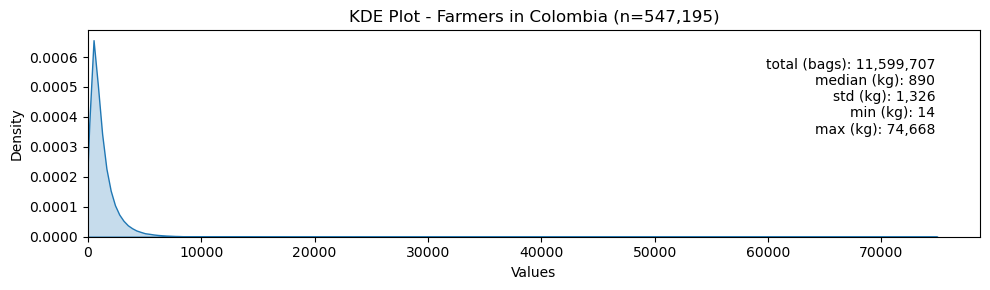

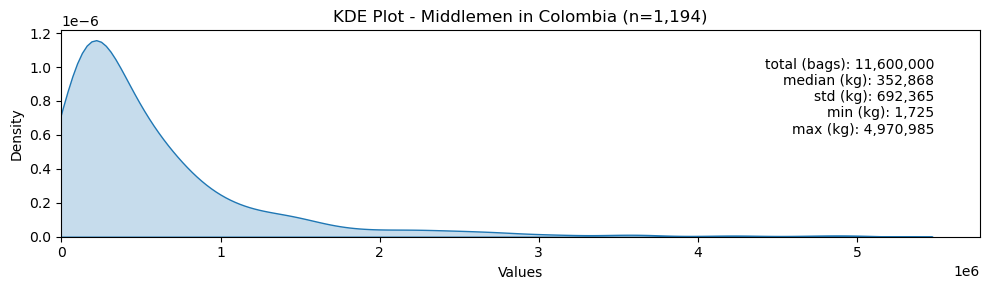

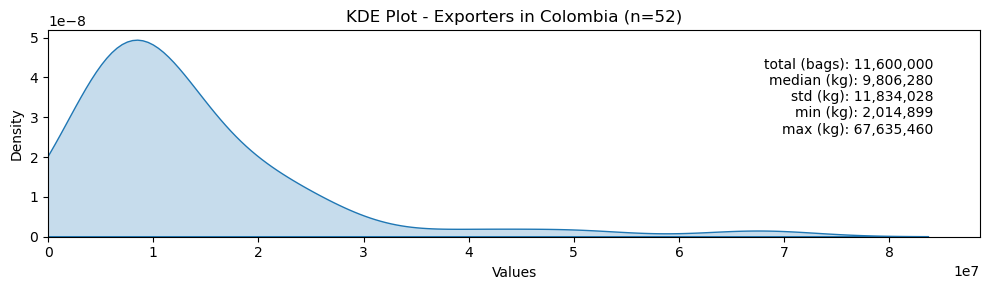

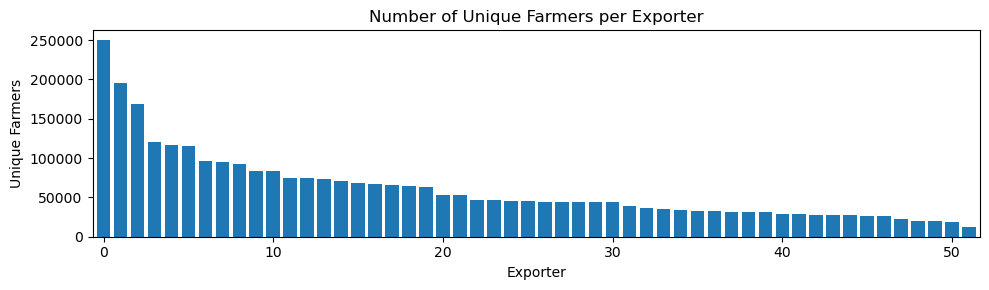

Number of unique farmers across 17 random exporters: 512,783 out of 547,195 total in country.


In [4]:
country = 'Colombia'
country_df = df_raw[df_raw["country"] == country]

farmers_df = country_df[country_df["source"].str.startswith("F")]
num_farmers = farmers_df['source'].nunique()
plot_kde(farmers_df, "source", "value", f"KDE Plot - Farmers in {country}", f"kde_farmers_{country}.png")

middlemen_df = country_df[country_df["source"].str.startswith("M")]
plot_kde(middlemen_df, "source", "value", f"KDE Plot - Middlemen in {country}", f"kde_middlemen_{country}.png")

exporters_df = country_df[country_df["target"].str.startswith("E")]
plot_kde(exporters_df, "target", "value", f"KDE Plot - Exporters in {country}", f"kde_exporters_{country}.png")

middleman_to_farmers = (
    country_df[country_df["source"].str.startswith("F")]
    .groupby("target")["source"]
    .apply(set)
    .to_dict()
)

exporter_to_middlemen = (
    country_df[country_df["source"].str.startswith("M")]
    .groupby("target")["source"]
    .apply(set)
    .to_dict()
)

farmers_per_exporter = {
    exporter: set.union(
        *(middleman_to_farmers.get(middleman, set()) for middleman in middlemen)
    )
    for exporter, middlemen in exporter_to_middlemen.items()
}

farmer_counts = {exporter: len(farmers) for exporter, farmers in farmers_per_exporter.items()}

pd.Series(farmer_counts).sort_values(ascending=False).plot(kind="bar", width=.8, figsize=(10, 3))
plt.title("Number of Unique Farmers per Exporter")

plt.xlabel("Exporter")
total_exporters = len(farmers_per_exporter)
xtick_interval = 10
plt.xticks(
    ticks=range(0, total_exporters, xtick_interval),
    labels=range(0, total_exporters, xtick_interval),
    rotation=0
)

plt.ylabel("Unique Farmers")
plt.tight_layout()
plt.show()

N = total_exporters // 3
random_exporters = random.sample(list(farmers_per_exporter.keys()), min(N, len(farmers_per_exporter)))
random_farmers_union = set.union(*(farmers_per_exporter[exporter] for exporter in random_exporters))

print(f"Number of unique farmers across {N} random exporters: {len(random_farmers_union):,.0f} out of {num_farmers:,.0f} total in country.")